In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as plx
import seaborn as sns
import json
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
prices = pd.read_parquet('data/stooq/daily/us/all_stocks_processed.parquet')

In [3]:
prices.columns = [col[1:-1].lower() for col in prices.columns]

In [4]:
stooq_dir = 'data/stooq'
fundamentals_dir = 'data/sec/companyfacts'
tickers_path = 'data/sec/company_tickers.json'

In [5]:
period = 'daily'
market = 'us'
sample_companies = [
    'MSFT.US',
    'AVGO.US',
    'NVDA.US',
    'TSM.US',
    'TSLA.US',
    'META.US',
    'IBM.US',
    'AAPL.US',
    'ASML.US',
    'AMZN.US',
    'GOOG.US',
    'LLY.US',
    'WMT.US',
    'JPM.US',
    'V.US',
    'UNH.US',
    'XOM.US',
    'ORCL.US',
    'MA.US'
]

In [6]:
cik_by_ticker = None
with open(tickers_path, 'r') as file:
    cik_by_ticker = json.load(file)
cik_by_ticker = { value['ticker'] + '.US': value['cik_str'] for _key, value in cik_by_ticker.items() }

In [7]:
prices['cik'] = prices.ticker.map(cik_by_ticker)
prices.dropna(inplace=True)
prices['cik'] = prices.cik.astype(int)

In [8]:
prices.drop(columns=['delta_date', 'daily_log_return'], inplace=True, errors='ignore')
prices.set_index(['cik', 'date'], inplace=True)
prices.drop_duplicates(inplace=True)

In [9]:
prices = prices[~prices.index.duplicated(keep='first')]

In [10]:
prices

ticker     open     high      low      close  \
cik     date                                                        
1090872 1999-11-19     A.US  27.8972  27.9371  25.8613  26.239520   
        1999-11-22     A.US  26.8370  28.5858  26.0278  28.595501   
        1999-11-23     A.US  27.6102  28.3377  25.9889  25.994932   
        1999-11-24     A.US  26.0637  27.2445  25.9889  26.682859   
        1999-11-26     A.US  26.5569  26.9585  26.4752  26.769284   
...                     ...      ...      ...      ...        ...   
846475  2024-05-24  ZYXI.US  10.2900  10.5200  10.2500  10.525519   
        2024-05-28  ZYXI.US  10.5300  10.5450  10.0100  10.110169   
        2024-05-29  ZYXI.US  10.1100  10.1100   9.9300  10.029619   
        2024-05-30  ZYXI.US  10.0500  10.1200   9.8800   9.920865   
        2024-05-31  ZYXI.US   9.9900  10.2000   9.8700  10.158825   

                             vol    return  log_close  log_return  
cik     date                                                       
1090872 1999-11-19  1.677358e+07  0.917694   3.267267   -0.085891  
        1999-11-22  7.242576e+06  1.089788   3.353249    0.085983  
        1999-11-23  6.579458e+06  0.909057   3.257902   -0.095348  
        1999-11-24  5.332648e+06  1.026464   3.284021    0.026120  
        1999-11-26  1.904229e+06  1.003239   3.287255    0.003234  
...                          ...       ...        ...         ...  
846475  2024-05-24  8.810700e+04  1.022485   2.353803    0.022236  
        2024-05-28  1.407030e+05  0.960539   2.313542   -0.040261  
        2024-05-29  1.221660e+05  0.992033   2.305543   -0.007999  
        2024-05-30  1.627040e+05  0.989157   2.294640   -0.010903  
        2024-05-31  1.377540e+05  1.023986   2.318343    0.023703  

[17065808 rows x 9 columns]

In [11]:
#pivot pivot_table unstack
log_returns = prices.reset_index().pivot(index='date', columns='cik', values='log_return')

In [12]:
log_returns = log_returns[log_returns.index >= datetime(2000, 1, 1)]

In [13]:
least_missing = (log_returns.isna().sum() / len(log_returns)).sort_values().index

In [14]:
log_returns = log_returns.drop(columns=least_missing[500:]).dropna()

In [15]:
scaler = StandardScaler()
scaled_log_returns = scaler.fit_transform(log_returns)

In [16]:
pca = PCA()
pca_results = pca.fit_transform(scaled_log_returns)

In [17]:
pca_results = pd.DataFrame(pca_results)
pca_results.index = log_returns.index
pca_results.columns = log_returns.columns

In [18]:
volatility = pca_results.rolling(5).std() / 5

In [20]:
volatility

cik,1800,2488,2809,2969,4904,4962,4977,5272,5513,6281,...,1674862,1675149,1739940,1744489,1770450,1800227,1820877,1835632,1841666,1973832
date,,,,,,,,,,,,,,,,,,,,,
2005-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08,0.664108,0.243560,0.437694,0.262403,0.092237,0.261040,0.227084,0.394585,0.271742,0.156712,...,0.052995,0.045199,0.031170,0.084406,0.050938,0.055740,0.081567,0.045186,0.022909,0.021942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-07,1.767334,1.095547,0.546193,0.327162,0.487447,0.487753,0.505603,0.540690,0.480922,0.220283,...,0.063069,0.102149,0.033085,0.050040,0.055175,0.058119,0.092526,0.056500,0.048320,0.045429
2024-02-08,1.359387,0.556260,0.476769,0.135042,0.305391,0.395254,0.293186,0.459885,0.541611,0.162926,...,0.073248,0.111930,0.016014,0.048110,0.054607,0.091627,0.092107,0.044733,0.048654,0.043302
2024-02-09,1.344420,0.464759,0.297438,0.118776,0.246255,0.393210,0.258773,0.556543,0.458092,0.285668,...,0.072770,0.104201,0.017280,0.051844,0.055129,0.080043,0.040822,0.024745,0.029138,0.048452


In [21]:
plx.line(
    data_frame=volatility.reset_index(names='date'),
    x='date',
    y=1800,
)

/home/pedro/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


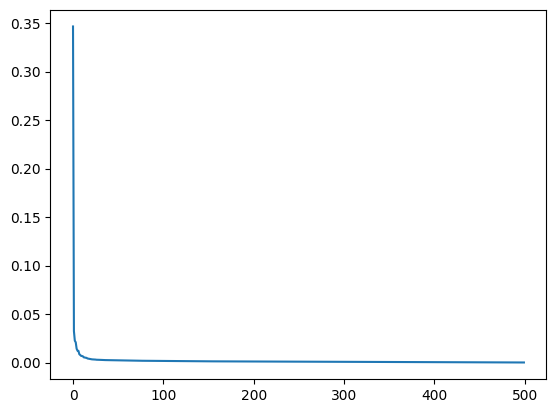

In [22]:
plt.plot(pca.explained_variance_ratio_)

In [23]:
plx.line(
    #data_frame=volatility.reset_index(names='date'),
    #x='date',
    y=pd.Series(pca.components_[0]).sort_values(),
)

In [24]:
cik_vanilla = [log_returns.columns[index] for index in pd.Series(pca.components_[0]).sort_values().index]

In [25]:
cik_vanilla = cik_vanilla[:10]

In [26]:
cik_vanilla

[773840, 76334, 1113169, 29905, 49826, 32604, 38777, 914208, 1037868, 1004434]

In [27]:
ticker_by_cik = {value: key for key, value in cik_by_ticker.items()}

In [28]:
list(map(lambda cik: ticker_by_cik[cik], cik_vanilla))

['HON.US',
 'PH.US',
 'TROW.US',
 'DOV.US',
 'ITW.US',
 'EMR.US',
 'BEN.US',
 'IVZ.US',
 'AME.US',
 'MGRD.US']